# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    # "Recall"      : evaluators.recall,
    # "Unpopularity": evaluators.unpopularity,
    # "Unpopularity2": evaluators.unpopularity2,
    # "Unpopularity3": evaluators.unpopularity3,
    # "F1-score"    : evaluators.f1_score,
    # "F1-score2"    : evaluators.f1_score2,
    # "F1-score3"    : evaluators.f1_score3,
    "my_metric1"   : evaluators.my_metric1,
    "my_metric2"   : evaluators.my_metric2
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 30
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,3.682944,0.088789,3.380272,0.084976,3.138032,0.077778


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,7.620241,0.594307,7.164044,0.480624,4.531833,0.206105


## CML+MP

In [9]:
n_item_sample = 30
n_user_sample = 30
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.MutualProximity(model, gamma, n_item_sample, n_user_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,12.47198,0.346682,10.327266,0.302861,5.667284,0.162767


bias=0.1


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,12.19806,0.428711,10.66683,0.351141,5.550158,0.169947


bias=0.2


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,11.878042,0.45608,10.388958,0.376431,5.572469,0.177918


bias=0.3


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,12.019462,0.477838,10.156582,0.392923,5.496849,0.183975


bias=0.4


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,11.512815,0.491476,9.994397,0.407621,5.407924,0.188967


bias=0.5


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,10.665318,0.500603,9.491604,0.419587,5.332693,0.193601


bias=0.6


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,10.820616,0.523162,9.422444,0.428652,5.257702,0.198571


bias=0.7


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,10.360724,0.536975,9.21285,0.445079,5.131326,0.201033


bias=0.8


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,10.349948,0.545217,8.880504,0.451759,5.018107,0.203652


bias=0.9


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,9.930333,0.564418,8.491186,0.465981,4.777469,0.205845


bias=1.0


,my_metric1@5,my_metric2@5,my_metric1@10,my_metric2@10,my_metric1@50,my_metric2@50
0,7.630993,0.594688,7.164989,0.480634,4.531833,0.206105


In [11]:
re_1 = []
re_2 = []
for re in re_mpcml_li:
    re_1.append(re.iloc[-1, 2])
    re_2.append(re.iloc[-1, 3])

In [12]:
re_base_1 = []
re_base_2 = []
for _ in range(len(bias_li)):
    re_base_1.append(re_base.iloc[-1, 2])
    re_base_2.append(re_base.iloc[-1, 3])

## my_metric1

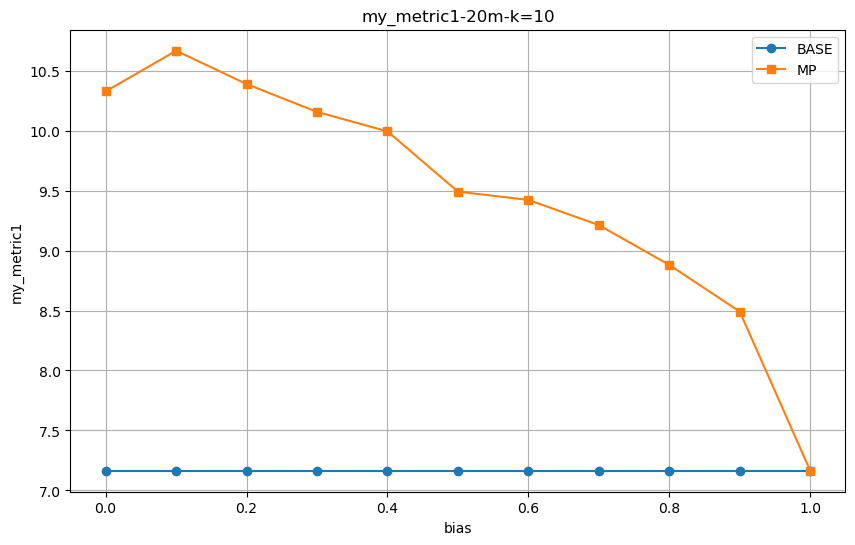

In [13]:
# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(bias_li, re_base_1, label='BASE', marker='o')
plt.plot(bias_li, re_1, label='MP', marker='s')

# タイトルとラベルの追加
plt.title('my_metric1-20m-k=10')
plt.xlabel('bias')
plt.ylabel('my_metric1')
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフの表示
plt.show()

## me_metric2

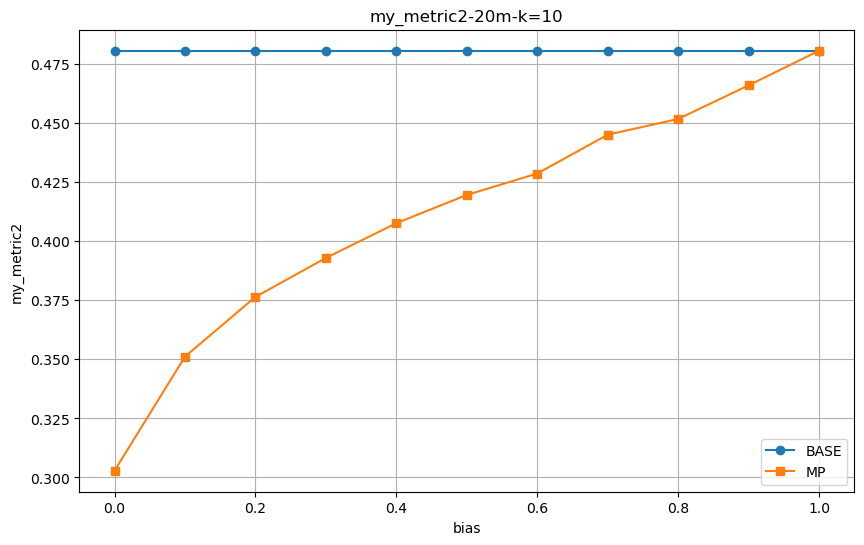

In [14]:
# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(bias_li, re_base_2, label='BASE', marker='o')
plt.plot(bias_li, re_2, label='MP', marker='s')

# タイトルとラベルの追加
plt.title('my_metric2-20m-k=10')
plt.xlabel('bias')
plt.ylabel('my_metric2')
plt.legend()

# グリッドを表示
plt.grid(True)

# グラフの表示
plt.show()